# Model Selection

In [1]:
# Import libraries
# type: ignore
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Imbalance datasets
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Linear model
from sklearn.linear_model import LogisticRegression

# Non-linear model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Tree-based model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix

In [2]:
# Read data
def read_data(filename):
    X = pd.read_csv(f"../Data/process/{filename}_transform.csv", header=0)
    return X

# Save model
def save_model(filename, model):
    with open(f"../Model/{filename}.pkl", 'wb') as f:
        pickle.dump(model, f)

In [3]:
# Read transformed training data
train_df = read_data('train')
valid_df = read_data('valid') # Validation data

# View
train_df.head()

,credit_score,age,tenure,num_of_products,balance,salary,age_label_proportion,avg_credit_score_by_age,geography_france,geography_germany,...,is_active_member,age_young,age_old,zero_balance,new_customer,old_customer,single_product,mt3_product,is_female,churn
0,-0.694374,0.480890,-0.009572,0.797297,0.295612,0.124178,-0.399331,-1.187795,1,0,...,1,0,0,0,0,0,0,0,1,0
1,-2.049957,-0.091560,1.022171,-0.913029,0.696248,0.528050,1.003343,0.129728,0,1,...,0,0,0,0,0,0,1,0,1,0
2,1.571829,0.385481,-0.697401,-0.913029,-1.240550,-0.478379,-0.399331,-1.187795,0,0,...,0,0,0,1,0,0,1,0,0,0
3,-0.518459,0.194665,-0.697401,0.797297,-1.240550,-0.787547,-0.399331,-1.187795,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-1.242816,0.290073,0.334342,0.797297,0.177637,-0.422558,-0.399331,-1.187795,0,1,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# target distribution
train_df['churn'].value_counts()

churn
0    4777
1    1223
Name: count, dtype: int64

- *The given dataset has imbalance class distribution.*

In [5]:
# Separate features and target variables.
X_train = train_df.drop(['churn'], axis=1).copy()
X_valid = valid_df.drop(['churn'], axis=1).copy()

y_train = train_df['churn']
y_valid = valid_df['churn']

### Handle Imbalance Dataset

Handle imbalance class distribution in dataset by adjusting class-weights.

In [6]:
# Compute weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

{np.int64(0): np.float64(0.6280092108017584),
 np.int64(1): np.float64(2.4529844644317254)}

In [7]:
def evaluate_cross_validation(models, X, y):
    # Perform 10-fold cross-validation to select the best model.
    scores = []
    for name, model in models:
        CV = StratifiedKFold(10)
        score = cross_val_score(model, X, y, scoring='recall', cv=CV, n_jobs=-1)
        scores.append((name, score.mean()))
        print("%s ==> %.3f +-(%.2f)" %(name, score.mean(), score.std()))
        
    return scores

In [8]:
# List of machine learning classification alogrithms
models = []
models.append(('LR', LogisticRegression(class_weight=weights_dict, random_state=42)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive', GaussianNB()))
models.append(('SVM', SVC(random_state=42, class_weight=weights_dict)))
models.append(('CART', DecisionTreeClassifier(random_state=42, class_weight=weights_dict)))
models.append(('RF', RandomForestClassifier(random_state=42, class_weight=weights_dict)))
models.append(('GB', GradientBoostingClassifier(random_state=42)))
models.append(('XGB', XGBClassifier(random_state=42, class_weight=weights_dict)))

In [9]:
# Model performance with default setting
model_scores = evaluate_cross_validation(models, X_train, y_train)

# Save results in dataframe
model_scores_df = pd.DataFrame(model_scores, columns=['Classifier', 'Recall'])

LR ==> 0.746 +-(0.04)
KNN ==> 0.411 +-(0.05)
Naive ==> 0.119 +-(0.03)
SVM ==> 0.749 +-(0.04)
CART ==> 0.473 +-(0.05)
RF ==> 0.417 +-(0.06)
GB ==> 0.455 +-(0.03)
XGB ==> 0.484 +-(0.05)


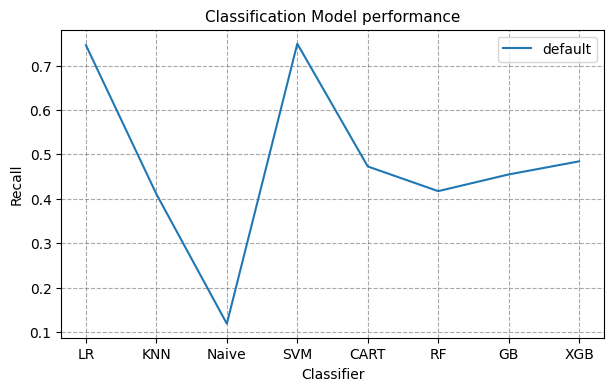

In [10]:
# Model perfromance visualization
fig = plt.figure(figsize=(7, 4))
sns.lineplot(model_scores_df, x='Classifier', y='Recall', label='default')
plt.grid(ls='--', color='#555', alpha=0.5)
plt.title("Classification Model performance", size=11);

- *Class weights significantly improves the performance of the models.*
- *SVM and Logisitic Regression outperforms other classifier with highest Recall 0.74.*

### Model Optimization

Let's further evaluate following classifier model using GridSearch cross-validation method to find the optimal model that perform good on validation data.

- Logistic Regression
- KNearest Classifier
- Gradient Boosting Classifier
- XGBoost Classifier
- Random Forest Classifer
- Support Vector Machines.

In [11]:
# Functions to evalaute the model using GridSearch algorithm
def get_search_score(y_true, y_preds_proba, threshold=0.5):
    # Convert predictions into 0 and 1 based on threshold
    y_preds = (y_preds_proba > threshold).astype(int)
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    
    # Precision, Recall, F1-Score
    precision, recall, f1score, support = precision_recall_fscore_support(y_true, y_preds, average='macro')
    return precision, recall, f1score, cm


def evaluate_search_model(model, name):
    
    # Fit the model on training data
    model.fit(X_train, y_train)

    try:
        # Make predictions
        y_train_preds = model.predict_proba(X_train)[:, 1]
        y_valid_preds = model.predict_proba(X_valid)[:, 1]

    except:
        # Make predictions
        y_train_preds = model.predict(X_train)
        y_valid_preds = model.predict(X_valid)

    # Compute score
    t_roc = roc_auc_score(y_train, y_train_preds)
    v_roc = roc_auc_score(y_valid, y_valid_preds)
 
    t_precision, t_recall, t_f1score, t_cm= get_search_score(y_train, y_train_preds)
    v_precision, v_recall, v_f1score, v_cm = get_search_score(y_valid, y_valid_preds)

    # Convert results into DataFrame
    train_scores = [t_roc, t_precision, t_recall, t_f1score]
    valid_scores = [v_roc, v_precision, v_recall, v_f1score]
    
    clf_score_df = pd.DataFrame(
                            data = {
                                'training_score': train_scores,
                                'validation_score' : valid_scores
                            },
                            index = ['roc-auc-score', 'precision', 'recall', 'f1-score']
                        )

    # Add classifier score into scoring dataframe.
    score_df.loc[len(score_df)] = [name] + train_scores + valid_scores
    
    return model, clf_score_df, v_cm

In [12]:
# Define the score dataframe that stores the metrics score for each model.
score_df = pd.DataFrame(
    columns = ['Classifier',
               'Train-ROC-AUC', 'Train Precision', 'Train Recall', 'Train F1Score',
               'Valid-ROC-AUC', 'Valid Precision', 'Valid Recall', 'Valid F1Score']
)

In [13]:
# define function to plot learning curves
def plot_learning_curve(best_score, clf_score_df):
    # Set figure size
    fig = plt.figure(figsize=(7, 4))
   
    # line plot
    sns.lineplot(clf_score_df, x=clf_score_df.index, y='training_score', label='Training')
    sns.lineplot(clf_score_df, x=clf_score_df.index, y='validation_score', label='Validation')
    
    # Add labels
    plt.xlabel('Metrics')
    plt.ylabel('Prediction Score')
    plt.title(f"Training vs. Validation scores (Best score={best_score:.2f})", size=11)

    plt.ylim(ymin=0, ymax=1.1)
    plt.grid(ls='--', color='#555', alpha=0.5)
    plt.legend();

### Logistic Regression

In [14]:
# Define Logisitic Regression Model
LR_clf = LogisticRegression(solver='liblinear', class_weight=weights_dict, random_state=42)

In [15]:
# Set GridSearch to find best model
params = {
    'max_iter': [100, 500, 1000, 1500],
    'C' : np.linspace(0.0001, 1, num=10),
    'penalty': ['l2', None]
}

# Grid Search algorithm
LR_search_clf = GridSearchCV(estimator=LR_clf,
                             param_grid=params,
                             scoring='recall',
                             cv=StratifiedKFold(7, shuffle=True, random_state=42),
                             n_jobs=-1,
                             verbose=1,
                             return_train_score=True)

# Fit model on training data
LR_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 80 candidates, totalling 560 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight={np.int64(0): np.float64(0.6280092108017584),
                                                        np.int64(1): np.float64(2.4529844644317254)},
                                          random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.000e-04, 1.112e-01, 2.223e-01, 3.334e-01, 4.445e-01, 5.556e-01,
       6.667e-01, 7.778e-01, 8.889e-01, 1.000e+00]),
                         'max_iter': [100, 500, 1000, 1500],
                         'penalty': ['l2', None]},
             return_train_score=True, scoring='recall', verbose=1)

In [16]:
# GridSearch results
LR_CVresults = pd.DataFrame(LR_search_clf.cv_results_).dropna()
columns = ['mean_fit_time', 'mean_score_time', 
           'param_C', 'param_max_iter', 'param_penalty',
           'mean_train_score', 'mean_test_score']
LR_CVresults = LR_CVresults[columns]
LR_CVresults.head()

,mean_fit_time,mean_score_time,param_C,param_max_iter,param_penalty,mean_train_score,mean_test_score
0,0.032861,0.013285,0.0001,100,l2,0.678250,0.675384
2,0.041146,0.030573,0.0001,500,l2,0.678250,0.675384
4,0.033717,0.013000,0.0001,1000,l2,0.678250,0.675384
6,0.035860,0.012288,0.0001,1500,l2,0.678250,0.675384
8,0.052575,0.009430,0.1112,100,l2,0.756882,0.751443


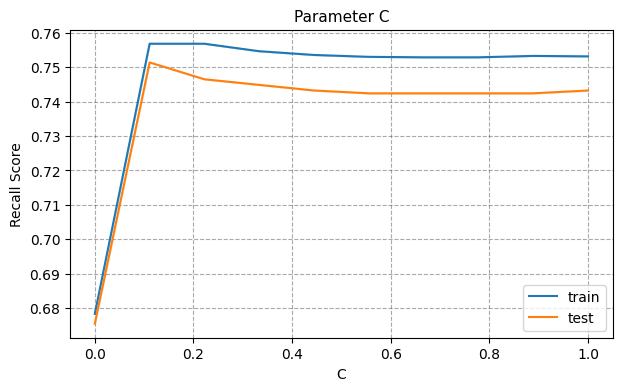

In [17]:
# Examine the logisitic Regression scores across different values of parameter C.
plt.figure(figsize=(7, 4))

sns.lineplot(LR_CVresults, x='param_C', y='mean_train_score', label='train')
sns.lineplot(LR_CVresults, x='param_C', y='mean_test_score', label='test')

# Add labels
plt.xlabel('C')
plt.ylabel('Recall Score')
plt.title("Parameter C", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

- *The above line plot compares the training and test scores for different values of parameter C.*
- *We can see, as the value of C increases the performance of logistic regression classifier decreases.*

#### Best Model Evaluation on validation - Logistic Regession

In [18]:
# Save best model
LR_best_clf = LR_search_clf.best_estimator_

# Evaluate the best classifer
LR_model, LR_score, LR_confusion_matrix = evaluate_search_model(LR_best_clf, 'Logistic Regression')

In [19]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.71297,0.836706,0.689985,0.758955,0.70457


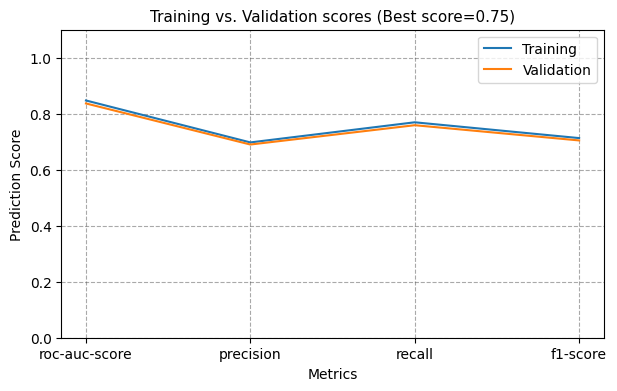

In [20]:
# Examine logistic regression performances on validation across different metrics
best_score = LR_search_clf.best_score_
plot_learning_curve(best_score, LR_score)

- *The above learning curves show that the overall performance of Logistic Regression on validation data is the same as on training data, as there is no sign of overfitting in the training.*

#### Precision Recall Curve 
To find optimal threshold value

In [21]:
# Find optimal threshold value
def find_threshold(model):
    # Make prediction using model
    y_preds = model.predict_proba(X_valid)[:, -1]
    
    # plot precision-recall curve
    precision, recall, threshold = precision_recall_curve(y_valid, y_preds)

    # Compute the f1-score
    threshold_df = pd.DataFrame(data={
        'precision': precision[:-1],
        'recall': recall[:-1], 
        'threshold': threshold
    })
    
    threshold_df['f1score'] = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    best_threshold = threshold_df.nlargest(1, 'f1score')['threshold'].values[0]
    
    # Plot precision-recall trade-off curve
    fig=plt.figure(figsize=(7, 4))
    plt.plot(precision, recall)
    
    # Add labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Trade-off", size=11)
    plt.grid(ls='--', color='#555', alpha=0.5)
    plt.show()
    
    return best_threshold, y_preds

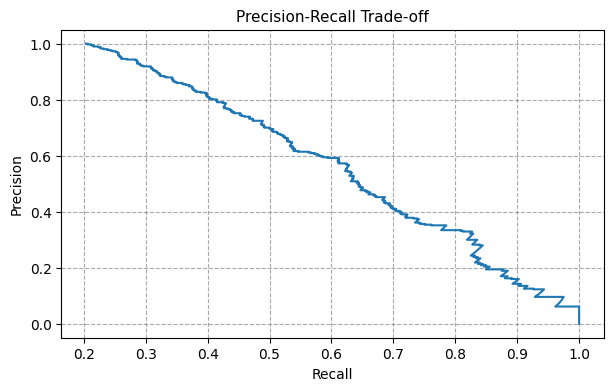

Best of Logistic Regression
------------------------------
Precision:: 0.7533833372126717
Recall:: 0.7468176959702384
F1-score:: 0.75
Confusion Matrix::
---------------
[[1440  153]
 [ 167  240]]


In [22]:
# Find the best threshold for Logistic Regression
best_threshold, y_preds = find_threshold(LR_model)

# Examine scores with best threshold value.
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, best_threshold)

print(f"Best of Logistic Regression\n{'---'*10}")
print("Precision::", precision)
print("Recall::", recall)
print("F1-score::", f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

In [23]:
# Save grid search Linear Regression
save_model('LR_model', LR_model)

### KNearest Neighbors

In [24]:
# Define KNN Classifier
KNN_clf = KNeighborsClassifier()

In [25]:
# Set GridSearch Parameters
params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 18, 21, 23]
}

# Define grid search for knn
KNN_search_clf = GridSearchCV(estimator=KNN_clf, 
                              param_grid=params, 
                              scoring='recall',
                              cv=StratifiedKFold(7, shuffle=True, random_state=42), 
                              n_jobs=-1, 
                              verbose=1, 
                              return_train_score=True)

# Fit the search algorithm on training data
KNN_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 15, 18, 21, 23]},
             return_train_score=True, scoring='recall', verbose=1)

In [26]:
# GridSearch results
KNN_CVresults = pd.DataFrame(KNN_search_clf.cv_results_).dropna()
columns = ['mean_fit_time', 'mean_score_time', 
           'param_n_neighbors', 'mean_train_score', 'mean_test_score']
KNN_CVresults = KNN_CVresults[columns]
KNN_CVresults.head()

,mean_fit_time,mean_score_time,param_n_neighbors,mean_train_score,mean_test_score
0,0.012001,0.185444,3,0.612976,0.420235
1,0.009143,0.170727,5,0.524799,0.406324
2,0.010857,0.166871,7,0.475195,0.389951
3,0.008858,0.168727,9,0.442078,0.371147
4,0.010285,0.191301,11,0.418504,0.361389


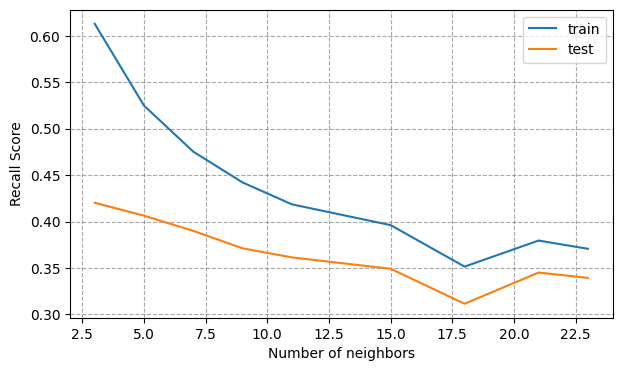

In [27]:
# Examine the logisitic Regression scores across different values of parameter C.
plt.figure(figsize=(7, 4))

sns.lineplot(KNN_CVresults, x='param_n_neighbors', y='mean_train_score', label='train')
sns.lineplot(KNN_CVresults, x='param_n_neighbors', y='mean_test_score', label='test')

# Add labels
plt.xlabel('Number of neighbors')
plt.ylabel('Recall Score')
plt.title("", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

#### Best Model Evaluation - KNN

In [28]:
# Best model - knn
KNN_best_clf = KNN_search_clf.best_estimator_

# Evaluate the best classifer
KNN_model, KNN_score, KNN_confusion_matrix = evaluate_search_model(KNN_best_clf, 'KNN')

In [29]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.712970,0.836706,0.689985,0.758955,0.704570
1,KNN,0.944583,0.857719,0.787688,0.815492,0.734269,0.698437,0.661190,0.675292


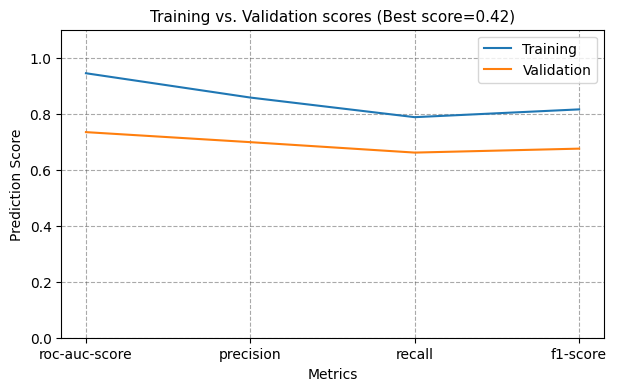

In [30]:
# Exmaine performance of K-nearest model to detect any overfitting present.
best_score = KNN_search_clf.best_score_
plot_learning_curve(best_score, KNN_score)

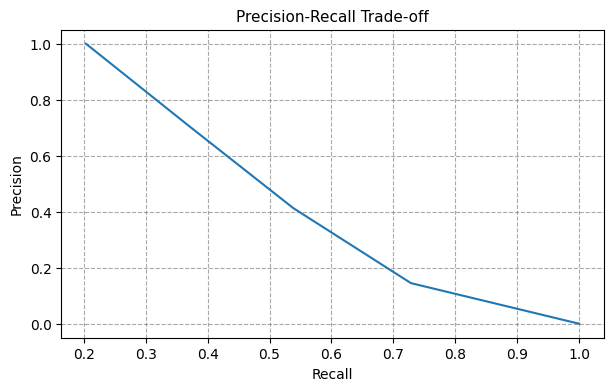

Best of K-Nearest Neighbors
------------------------------
Precision:: 0.698
Recall:: 0.661
F1-score:: 0.675
Confusion Matrix::
---------------
[[1449  144]
 [ 239  168]]


In [31]:
# Find the best threshold for Logistic Regression
KNN_best_threshold, y_preds = find_threshold(KNN_model)

# Examine scores with best threshold value.
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, KNN_best_threshold)

print(f"Best of K-Nearest Neighbors\n{'---'*10}")
print("Precision:: %.3f" %precision)
print("Recall:: %.3f" %recall)
print("F1-score:: %.3f" %f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

In [32]:
# Save grid search K-nearest neighbor classifier
save_model('KNN_model', KNN_model)

### Gradient Boosting Classifier

In [33]:
# Define the gradient boost classifier
GBM_clf = GradientBoostingClassifier(max_features='sqrt', n_iter_no_change=30, validation_fraction=0.3, random_state=42)

In [34]:
# Set parameters for gradient boosting classifier
params = {
    'n_estimators' : [10, 100, 200, 250, 300, 500, 800, 1100, 1200],
    'learning_rate': [0.001, 0.01, 0.02, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8]
}

# Define GridSearch for GBM
GBM_search_clf = GridSearchCV(estimator=GBM_clf,
                              param_grid=params,
                              scoring='recall',
                              n_jobs=-1,
                              cv=StratifiedKFold(7, shuffle=True, random_state=42),
                              verbose=1,
                              return_train_score=True)

# Fit the search algorithm on training data
GBM_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 324 candidates, totalling 2268 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_iter_no_change=30,
                                                  random_state=42,
                                                  validation_fraction=0.3),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.02, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [10, 100, 200, 250, 300, 500, 800,
                                          1100, 1200],
                         'subsample': [0.6, 0.7, 0.8]},
             return_train_score=True, scoring='recall', verbose=1)

In [35]:
# GridSearch results
GBM_CVresults = pd.DataFrame(GBM_search_clf.cv_results_).dropna()
columns = ['mean_fit_time', 'mean_score_time', 
           'param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_subsample', 
           'mean_train_score', 'mean_test_score']
GBM_CVresults = GBM_CVresults[columns]
GBM_CVresults.head()

,mean_fit_time,mean_score_time,param_n_estimators,param_learning_rate,param_max_depth,param_subsample,mean_train_score,mean_test_score
0,0.104008,0.008716,10,0.001,3,0.6,0.0,0.0
1,0.090007,0.013001,10,0.001,3,0.7,0.0,0.0
2,0.116581,0.011716,10,0.001,3,0.8,0.0,0.0
3,0.568331,0.011715,100,0.001,3,0.6,0.0,0.0
4,0.693914,0.011714,100,0.001,3,0.7,0.0,0.0


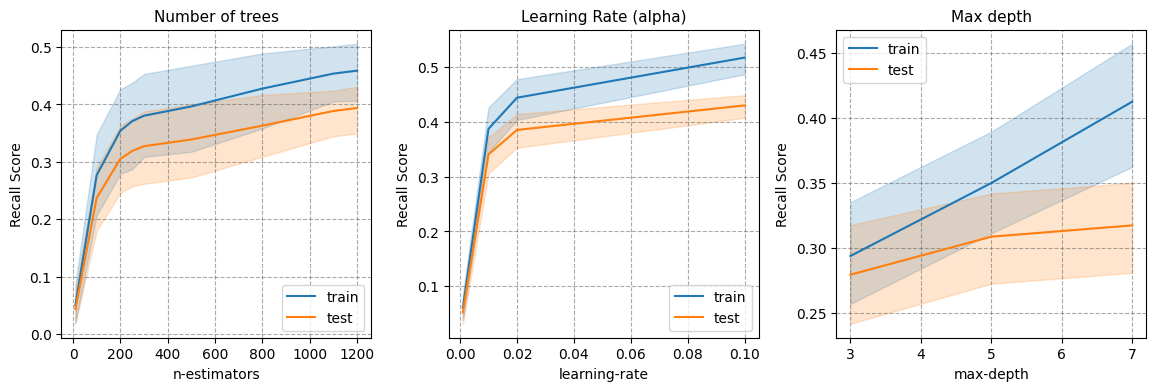

In [36]:
# Examine the training and validation scores over chaning parameter values.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(GBM_CVresults, x=f'param_n_estimators', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(GBM_CVresults, x=f'param_n_estimators', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(GBM_CVresults, x=f'param_learning_rate', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(GBM_CVresults, x=f'param_learning_rate', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(GBM_CVresults, x=f'param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(GBM_CVresults, x=f'param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of trees", size=11)
ax2.set_title("Learning Rate (alpha)", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('n-estimators')
ax2.set_xlabel('learning-rate')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('Recall Score')
ax2.set_ylabel('Recall Score')
ax3.set_ylabel('Recall Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

#### Best Model Evaluation - Gradient Boosting Classifier

In [37]:
# Best model - knn
GBM_best_clf = GBM_search_clf.best_estimator_

# Evaluate the best classifer
GBM_model, GBM_score, GBM_confusion_matrix = evaluate_search_model(GBM_best_clf, 'Gradient Boosting Classifier')

In [38]:
score_df

,Classifier,Train-ROC-AUC,Train Precision,Train Recall,Train F1Score,Valid-ROC-AUC,Valid Precision,Valid Recall,Valid F1Score
0,Logistic Regression,0.847319,0.697519,0.769379,0.712970,0.836706,0.689985,0.758955,0.704570
1,KNN,0.944583,0.857719,0.787688,0.815492,0.734269,0.698437,0.661190,0.675292
2,Gradient Boosting Classifier,0.879720,0.832523,0.738524,0.771136,0.854610,0.814129,0.714870,0.747177


In [39]:
GBM_confusion_matrix

array([[1530,   63],
       [ 216,  191]])

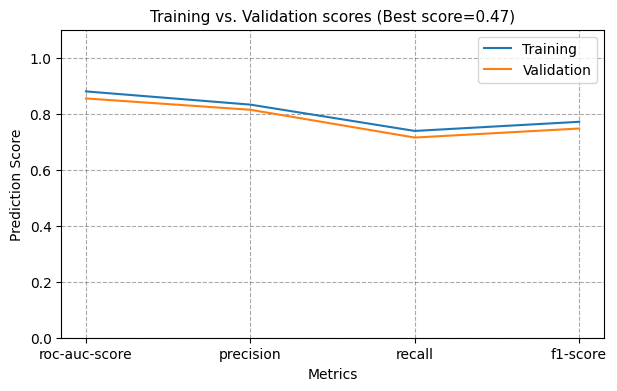

In [40]:
# Save the best model score
best_score = GBM_search_clf.best_score_
plot_learning_curve(best_score, GBM_score)

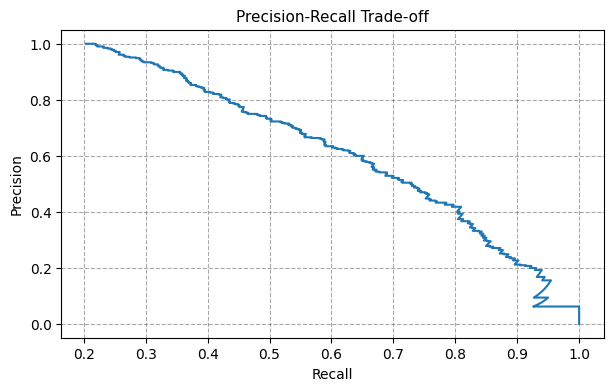

Best of Gradient Boosting Classifier
------------------------------
Precision:: 0.7753377571180695
Recall:: 0.757722283146012
F1-score:: 0.765886287625418
Confusion Matrix::
---------------
[[1463  130]
 [ 164  243]]


In [41]:
# Find the best threshold for Logistic Regression
GBM_best_threshold, y_preds = find_threshold(GBM_model)

# Examine scores with best threshold value.
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, GBM_best_threshold)

print(f"Best of Gradient Boosting Classifier\n{'---'*10}")
print("Precision::", precision)
print("Recall::", recall)
print("F1-score::", f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

In [42]:
# Save grid search gradient model
save_model('GBM_model', GBM_model)

### XGBoost Classifier

In [43]:
# Define the XGBoost classifier
XGB_clf = XGBClassifier(colsample_bytree=0.25, class_weight=weights_dict, random_state=42)

In [ ]:
# Set parameters for GradientSearch algorithms
params = {
    'n_estimators': [100, 200, 300, 500, 800, 1100, 1200],
    'learning_rate': [0.001, 0.01, 0.1, 0.02],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8]
}

# Define search algorithm
XGB_search_clf = GridSearchCV(estimator=XGB_clf,
                              param_grid=params,
                              scoring='recall',
                              n_jobs=-1,
                              cv=StratifiedKFold(7, shuffle=True, random_state=42),
                              verbose=1,
                              return_train_score=True)

# Fit the search algorithm on training data
XGB_search_clf.fit(X_train, y_train)

Fitting 7 folds for each of 252 candidates, totalling 1764 fits


In [ ]:
# Examine training & validation score from search algorithm
XGB_CVresults = pd.DataFrame(XGB_search_clf.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 
           'param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_subsample',
           'mean_train_score', 'mean_test_score']

XGB_CVresults = XGB_CVresults[columns]
XGB_CVresults.head()

In [ ]:
# Plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(XGB_CVresults, x='param_n_estimators', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(XGB_CVresults, x='param_n_estimators', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(XGB_CVresults, x='param_learning_rate', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(XGB_CVresults, x='param_learning_rate', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(XGB_CVresults, x='param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(XGB_CVresults, x='param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of trees", size=11)
ax2.set_title("Learning Rate", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('n-estimators')
ax2.set_xlabel('learning-rate')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('Recall Score')
ax2.set_ylabel('Recall Score')
ax3.set_ylabel('Recall Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

#### Best Model Evaluation - XGBoost Classifier

In [ ]:
# Evaluate best model on validation data
XGB_model = XGB_search_clf.best_estimator_
XGB_model, XGB_score, XGB_confusion_matrix = evaluate_search_model(XGB_model, 'XGBoost Classifer')
score_df

In [ ]:
# plot scores
best_score = XGB_search_clf.best_score_
plot_learning_curve(best_score, XGB_score)

- *The performance of the XGBoost model is very similar to that of Gradient Boosting.*
- *The best scores from the GridSearch algorithm for both classifiers are very low, but when measured on validation data, they show good recall.*

#### Precision-Recall Curve
Find best threshold for XGBoost Classifier

In [ ]:
XGB_best_threshold, y_preds = find_threshold(XGB_model)

# Model performance on best threshold
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, XGB_best_threshold)

print(f"Best of XGBoost Classifier\n{'---'*10}")
print("Precision::", precision)
print("Recall::", recall)
print("F1-score::", f1score)
print(f"Confusion Matrix::\n{'---'*5}")
print(cm)

In [ ]:
# Save grid search XGBoost classifer
save_model('XGB_model', XGB_model)

### Random Forest Classifier

In [ ]:
# Define default RandomForest Classifier
RF_clf = RandomForestClassifier(max_features='sqrt', class_weight=weights_dict, random_state=42)

In [ ]:
# Set parameters of Random forest for GridSearch algorithm
params = {
    'criterion': ['log_loss', 'entropy', 'gini'],
    'n_estimators': [10, 100, 200, 300, 500, 800, 1000, 1200],
    'max_depth': [3, 5, 7],
    'max_samples': [0.6, 0.7, 0.8]
}

# Define search algorithm
RF_search_clf = GridSearchCV(estimator=RF_clf,
                             param_grid=params,
                             scoring='recall',
                             cv=StratifiedKFold(7, shuffle=True, random_state=42),
                             n_jobs=-1,
                             verbose=1,
                             return_train_score=True)

# Fit the search algorithm on training data
RF_search_clf.fit(X_train, y_train)

In [ ]:
# Examine training and validation scores of Random forest Classifier
RF_CVresults = pd.DataFrame(RF_search_clf.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 
           'param_criterion', 'param_n_estimators', 'param_max_depth', 'param_max_samples',
           'mean_train_score', 'mean_test_score']

RF_CVresults = RF_CVresults[columns]
RF_CVresults.head()

In [ ]:
# Plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(RF_CVresults, x='param_max_samples', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(RF_CVresults, x='param_max_samples', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(RF_CVresults, x='param_n_estimators', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(RF_CVresults, x='param_n_estimators', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(RF_CVresults, x='param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(RF_CVresults, x='param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of samples", size=11)
ax2.set_title("Number of trees", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('max-samples')
ax2.set_xlabel('n-estimators')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('Recall Score')
ax2.set_ylabel('Recall Score')
ax3.set_ylabel('Recall Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

- *The above line plots show the performance of random forest classifiers over different parameter values.*
- *The large gaps in training and test scores indicate an overfitting model.*

#### Best model evaluation - Random Forest Classifier

In [ ]:
# Evaluate best model on validation data
RF_model = RF_search_clf.best_estimator_
RF_model, RF_score, RF_confusion_matrix = evaluate_search_model(RF_model, 'Random Forest Classifier')

In [ ]:
RF_score

In [ ]:
# Examine model performance on validation data using various metrics
best_score = RF_search_clf.best_score_
plot_learning_curve(best_score, RF_score)

In [ ]:
score_df

#### Precision-Recall Curve
Find optimal value for threshold using precision-recall curve

In [ ]:
RF_best_threshold, y_preds = find_threshold(RF_model)

# Model performance using threshold value
get_search_score(y_valid, y_preds, RF_best_threshold)

In [ ]:
# Save grid search random forest model
save_model('RF_model', RF_model)

### Support Vector Machine

In [ ]:
# Define classifier
SVM_clf = SVC(class_weight=weights_dict, random_state=42)

In [ ]:
# Set parameters of SVM Classifer for GridSearch algorithm
params = {
    'C': [1, 10, 15, 100, 1000],
    'max_iter': [-1, 10, 100, 1000]
}

# Define search algorithm
SVM_search_clf = GridSearchCV(estimator=SVM_clf,
                             param_grid=params,
                             scoring='recall',
                             cv=StratifiedKFold(7, shuffle=True, random_state=42),
                             n_jobs=-1,
                             verbose=1,
                             return_train_score=True)

# Fit the search algorithm on training data
SVM_search_clf.fit(X_train, y_train)

In [ ]:
# Examine training and validation scores of Random forest Classifier
SVM_CVresults = pd.DataFrame(SVM_search_clf.cv_results_)
columns = ['mean_fit_time', 'mean_score_time', 
           'param_C', 'param_max_iter', 'mean_train_score', 'mean_test_score']

SVM_CVresults = SVM_CVresults[columns]
SVM_CVresults.head()

#### Best model evaluation - SVM

In [ ]:
# Evaluate best model on validation data
SVM_model = SVM_search_clf.best_estimator_
SVM_model, SVM_score, SVM_confusion_matrix = evaluate_search_model(SVM_model, 'Support Vector Classifier')

In [ ]:
# Examine model performance on validation data using various metrics
best_score = SVM_search_clf.best_score_
plot_learning_curve(best_score, SVM_score)

- *The svm classifier has perfect score on training data. However when it perform poorly when measure on validation data.*

In [ ]:
score_df

### Ensembles : XGBoost, Random Forest, K-Neighbors, Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate the ensemble on validation data.
lr_preds = LR_model.predict_proba(X_valid)[:, 1]
rf_preds = RF_model.predict_proba(X_valid)[:, 1]
knn_preds = KNN_model.predict_proba(X_valid)[:, 1]
xgb_preds= XGB_model.predict_proba(X_valid)[:, 1]

# Select the most common prediction
y_preds = (lr_y_preds + rf_y_preds + knn_y_preds + xgb_y_preds ) / 4

# Compute scores at threshold 0.4
roc_score = roc_auc_score(y_valid, y_preds)
precision, recall, f1score, cm = get_search_score(y_valid, y_preds, 0.4)
y_preds = (y_preds > 0.4).astype(int)
accuracy = accuracy_score(y_valid, y_preds)

In [ ]:
print("Accuracy ==> %.3f" %accuracy)
print(f"ROC-AUC score ==> {roc_score:.2f}" )
print(f"Precision ==> {precision:.2f}\nRecall ==> {recall:.2f}")
print(f"F1-score ==> {f1score:.2f}\nConfusion Matrix ::\n{cm}")